# CPA tutorial

In [1]:
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd

import os
os.chdir('./../../..')
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
#!pip install cpa-tools 

In [3]:
import cpa
import scanpy as sc

Global seed set to 0


In [4]:
sc.settings.set_figure_params(dpi=150)

### Download reference data and setup

In [ ]:
import gdown

url = 'https://drive.google.com/uc?id=1Rnm-XKEqPLdOq3lpa3ka2aV4bOXVCLP0'
output = 'datasets/pbmc_tutorial.h5ad'
gdown.download(url, output, quiet=False)

In [5]:
adata = sc.read('/home/aletl/Documents/datasets/GSM_new.h5ad')
adata

AnnData object with n_obs × n_vars = 14811 × 4999
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split'
    var: 'id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dose_colors', 'drug_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'product_dose_colors', 'rank_genes_groups_cov', 'umap', 'vehicle_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [6]:
cpa.CPA.setup_anndata(adata, 
                      drug_key='condition', 
                      dose_key='dose_val',
                      control_key='control',
                      categorical_covariate_keys=['cell_type']
                     )

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             


/home/aletl/anaconda3/envs/sci-env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.
  warnings.warn(msg, category=FutureWarning)


INFO     Successfully registered anndata object containing 14811 cells, 4999 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


CPA takes the data from .X, where the raw counts are stored. The keys are the ones indicated in the setup_anndata function.

Also, the data has already been splitted in train, test and out-of-distribution.

In [7]:
adata.obs['split'].unique()

['test', 'ood', 'train']
Categories (3, object): ['ood', 'test', 'train']

### Train a model

To train a model, you can specify the parameters for both the model and the training in two different dictionaries. If parameters are not specified, default values are selected.

`ae_hparams` are technical parameters of the architecture of the autoencoder.

In [8]:
ae_hparams = {'autoencoder_depth': 4,
              'autoencoder_width': 512,
              'adversary_depth': 3,
              'adversary_width': 256,
              'dosers_depth': 3,
              'dosers_width': 64,
              'use_batch_norm': True,
              'use_layer_norm': False,
              'output_activation': 'linear',
              'dropout_rate': 0.0,
              'variational': False,
              'seed': 60,
              }

`trainer_params` contains the parameters related to training.

In [9]:
trainer_params = {
    'n_epochs_warmup': 0,
    'adversary_lr': 0.0006158304832265454,
    'adversary_wd': 3.546249921082396e-06,
    'adversary_steps': 5,
    'autoencoder_lr': 0.002563090275772759,
    'autoencoder_wd': 2.8299682410882683e-05,
    'dosers_lr': 0.0028643381083830787,
    'dosers_wd': 7.850495446598981e-07,
    'penalty_adversary': 6.20968938643343,
    'reg_adversary': 1.323092865499999,
    'kl_weight': 0.00000,
    'step_size_lr': 45,
}

In [10]:
model = cpa.CPA(adata=adata, 
                n_latent=256,
                loss_ae='gauss',
                doser_type='logsigm',
                split_key='split',
                **ae_hparams,
               )

/home/aletl/anaconda3/envs/sci-env/lib/python3.7/site-packages/scvi/model/base/_base_model.py:151: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  "Make sure the registered X field in anndata contains unnormalized count data."
Global seed set to 60


In [11]:
model.train(max_epochs=1500,
            use_gpu=False, 
            batch_size=64,
            early_stopping=True,
            plan_kwargs=trainer_params,
            early_stopping_patience=15,
            check_val_every_n_epoch=20,
            save_path='trained_models/lightning_logs/GSM_new/',
           )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name   | Type      | Params
-------------------------------------
0 | module | CPAModule | 9.7 M 
-------------------------------------
9.7 M     Trainable params
0         Non-trainable params
9.7 M     Total params
38.911    Total estimated model params size (MB)


Epoch 20/1500:   1%|█▌                                                                                                                     | 20/1500 [01:53<2:32:07,  6.17s/it, recon=-.248, adv_acc=0.278]

/home/aletl/anaconda3/envs/sci-env/lib/python3.7/site-packages/scvi/train/_callbacks.py:96: RuntimeWarning: Can save best module state only with cpa_metric available, skipping.
  RuntimeWarning,


Epoch 30/1500:   2%|█                                                       | 29/1500 [02:56<2:22:56,  5.83s/it, recon=-.259, adv_acc=0.293, val_recon=-1.32, val_disnt_basal=0.372, val_disnt_after=0.682]

/home/aletl/anaconda3/envs/sci-env/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:897: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn('Detected KeyboardInterrupt, attempting graceful shutdown...')


### Visualize loss functions

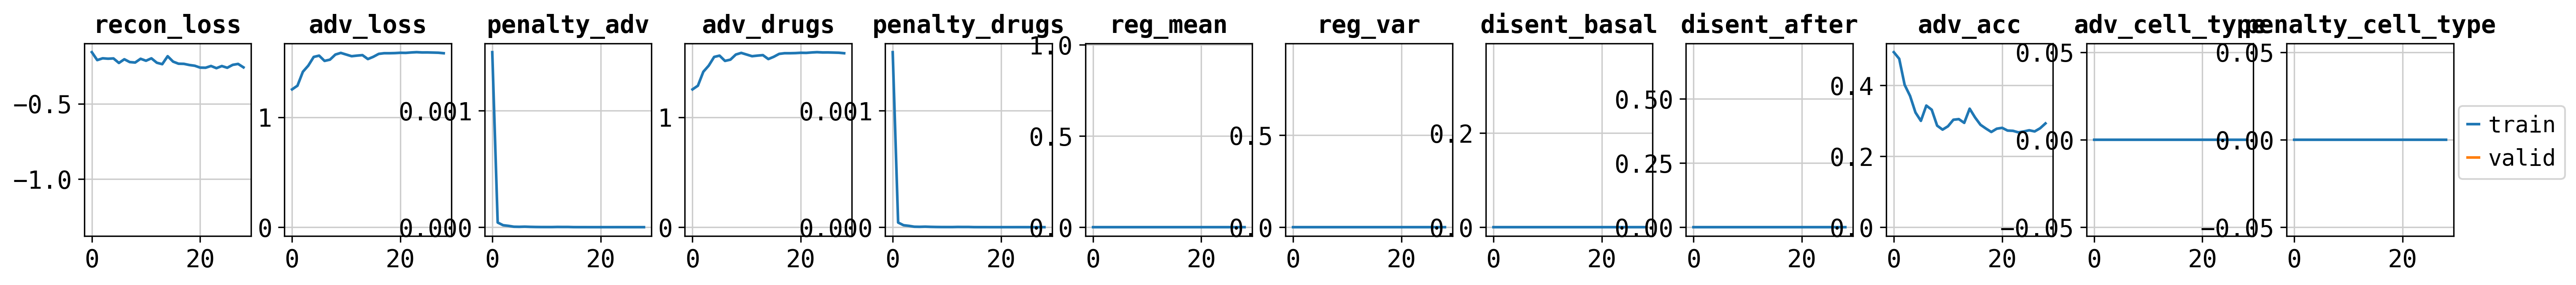

In [12]:
cpa.pl.plot_history(model)

### Working with the test data

In [15]:
test_dataset = adata[adata.obs['split'] == 'test']

In [16]:
latent_basal_adata, latent_adata = model.get_latent_representation(test_dataset, batch_size=1024)

INFO     Received view of anndata, making copy.                                              


/home/aletl/anaconda3/envs/sci-env/lib/python3.7/site-packages/scvi/model/base/_base_model.py:151: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  "Make sure the registered X field in anndata contains unnormalized count data."


In [17]:
sc.pp.neighbors(latent_basal_adata)
sc.tl.umap(latent_basal_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


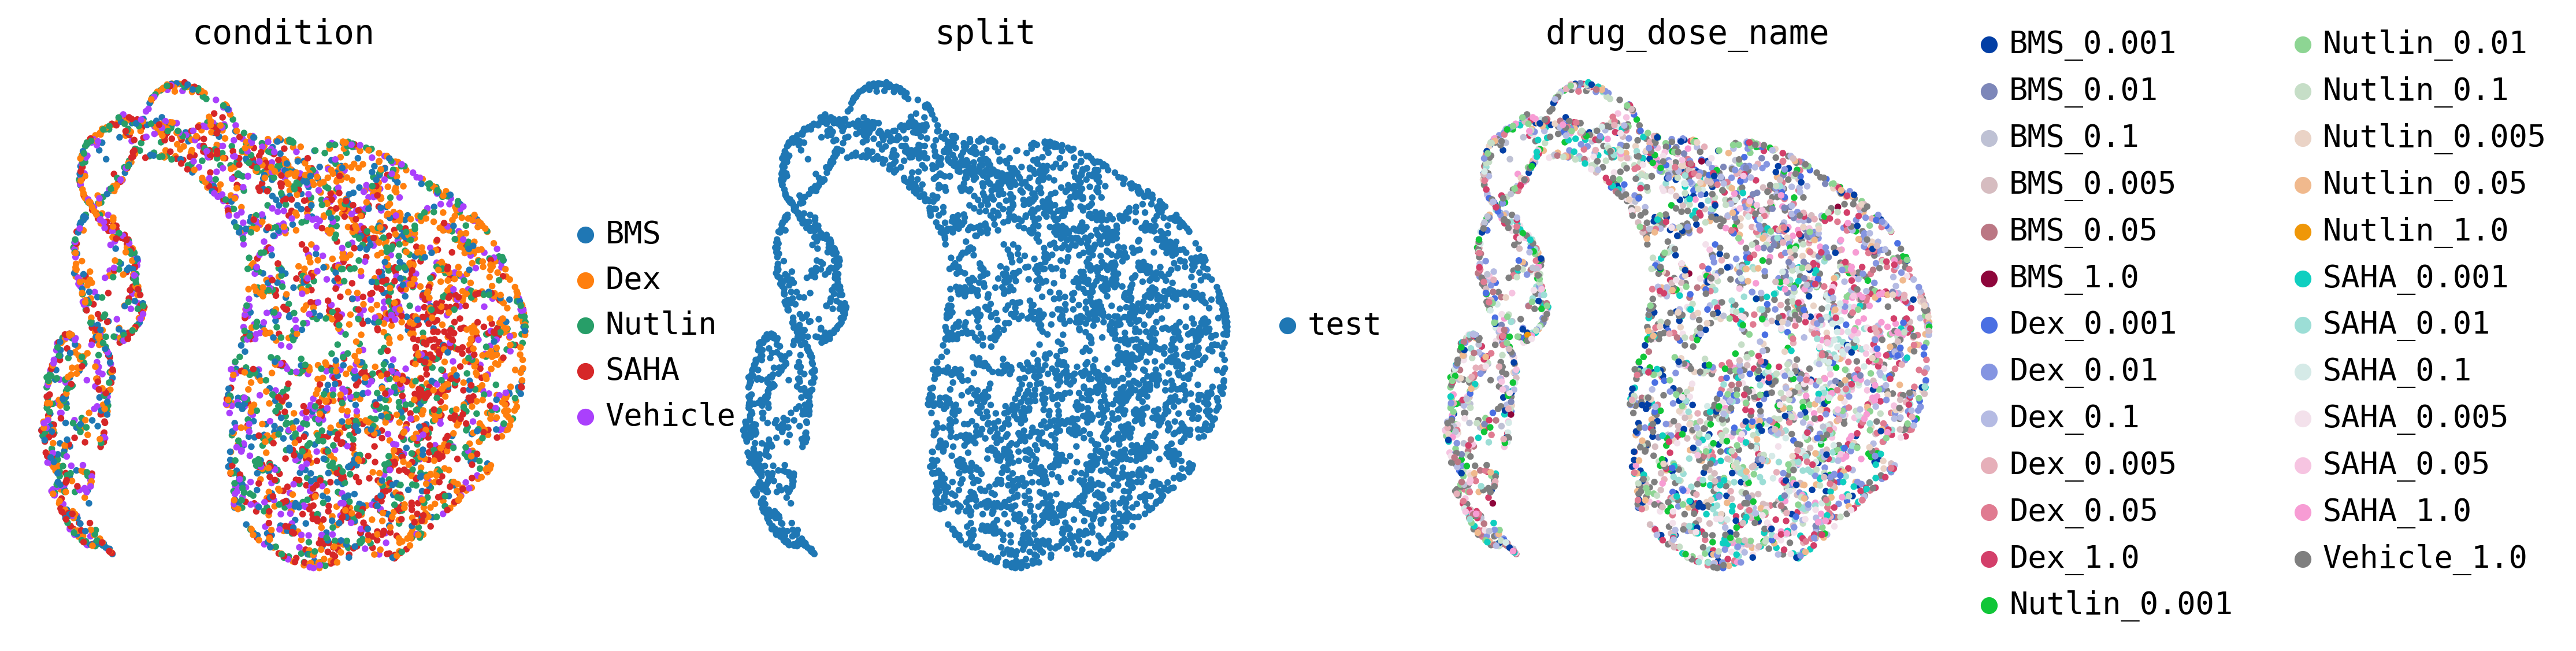

In [18]:
sc.pl.umap(latent_basal_adata, color=['condition', 'split', 'drug_dose_name'], frameon=False, wspace=0.2)

### ComPert API for compatibility with scanpy

This module allow us to plot different embeddings to gain insights about the data we are working with.

In [17]:
cpa_analyzer = cpa.ComPertAPI(adata, model)

In [18]:
perts_anndata = cpa_analyzer.get_drug_embeddings()
perts_anndata

AnnData object with n_obs × n_vars = 5 × 256
    obs: 'condition'

In [19]:
covars_anndata = cpa_analyzer.get_covars_embeddings('cell_type')
covars_anndata

AnnData object with n_obs × n_vars = 1 × 256
    obs: 'cell_type'

In [20]:
drug_adata = cpa_analyzer.get_drug_embeddings()
drug_adata.shape

(5, 256)

In [21]:
cpa_analyzer.num_measured_points['train']

{'A549_BMS_0.001': 442,
 'A549_BMS_0.005': 391,
 'A549_BMS_0.01': 262,
 'A549_BMS_0.05': 134,
 'A549_BMS_0.1': 103,
 'A549_BMS_1.0': 13,
 'A549_Dex_0.001': 204,
 'A549_Dex_0.005': 264,
 'A549_Dex_0.01': 479,
 'A549_Dex_0.05': 484,
 'A549_Dex_0.1': 486,
 'A549_Dex_1.0': 568,
 'A549_Nutlin_0.001': 284,
 'A549_Nutlin_0.005': 252,
 'A549_Nutlin_0.01': 387,
 'A549_Nutlin_0.05': 350,
 'A549_Nutlin_0.1': 457,
 'A549_Nutlin_1.0': 6,
 'A549_SAHA_0.001': 392,
 'A549_SAHA_0.005': 376,
 'A549_SAHA_0.01': 383,
 'A549_SAHA_0.05': 299,
 'A549_SAHA_0.1': 297,
 'A549_SAHA_1.0': 282,
 'A549_Vehicle_1.0': 1535}

In [22]:
cpa_analyzer.compute_comb_emb(thrh=0)
cpa_analyzer.compute_uncertainty(
                    covs='A549', 
                    pert='Nutlin', 
                    dose='1.0'
                )

(0.8600815, 3.8058097, 'A549_Nutlin_1.0', 'A549_Nutlin_1.0')

In [23]:
cpa_analyzer.measured_points['train']

{'A549': {'BMS': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
  'Dex': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
  'Nutlin': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
  'SAHA': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
  'Vehicle': [1.0]}}

In [24]:
cpa_plots = cpa.pl.CompertVisuals(cpa_analyzer, fileprefix=None)

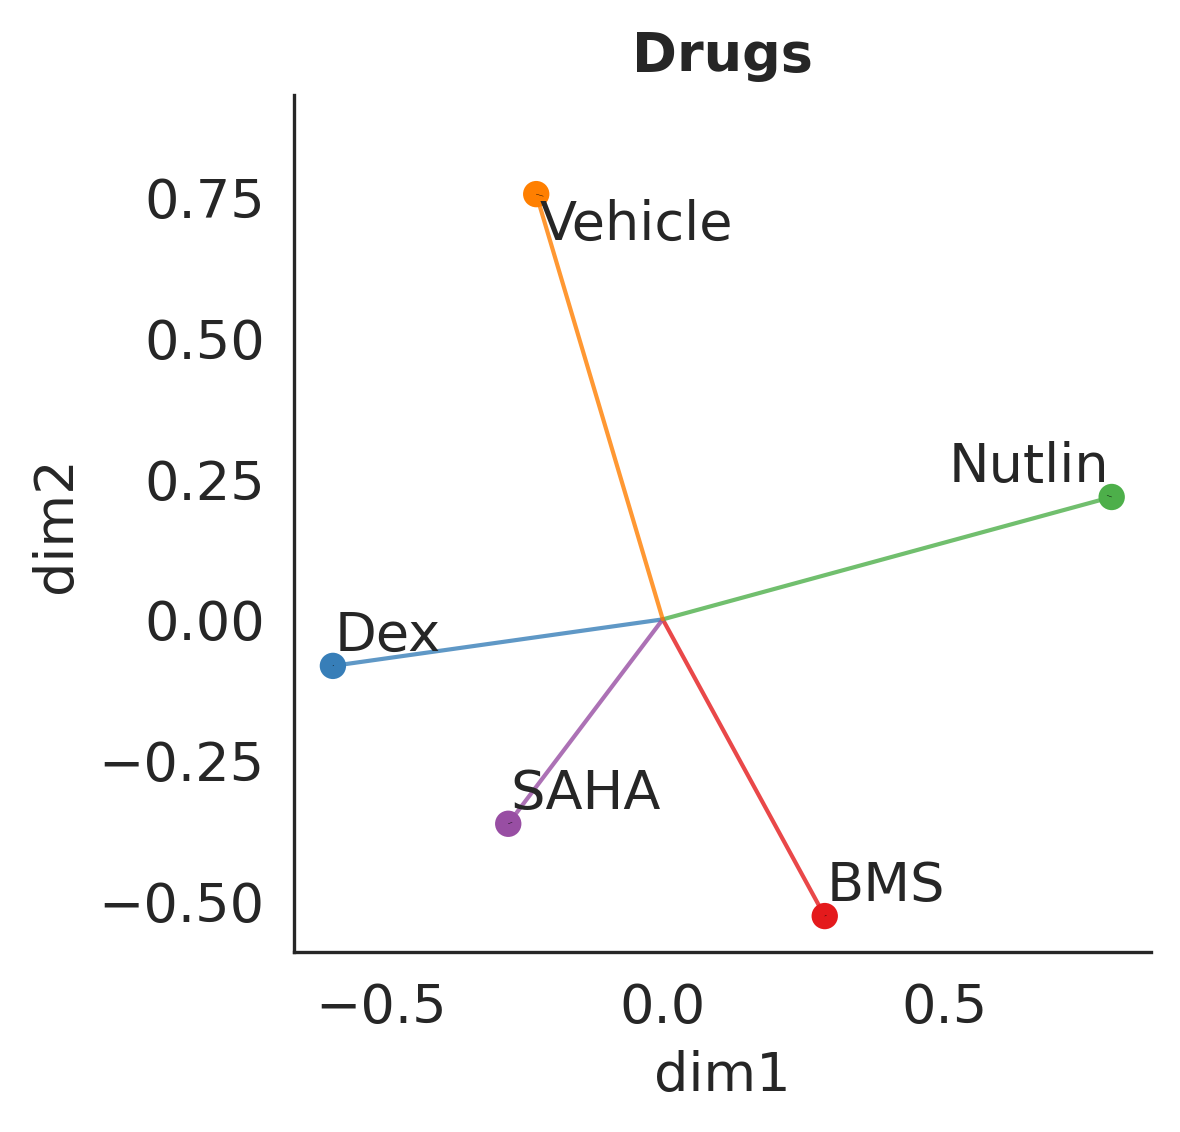

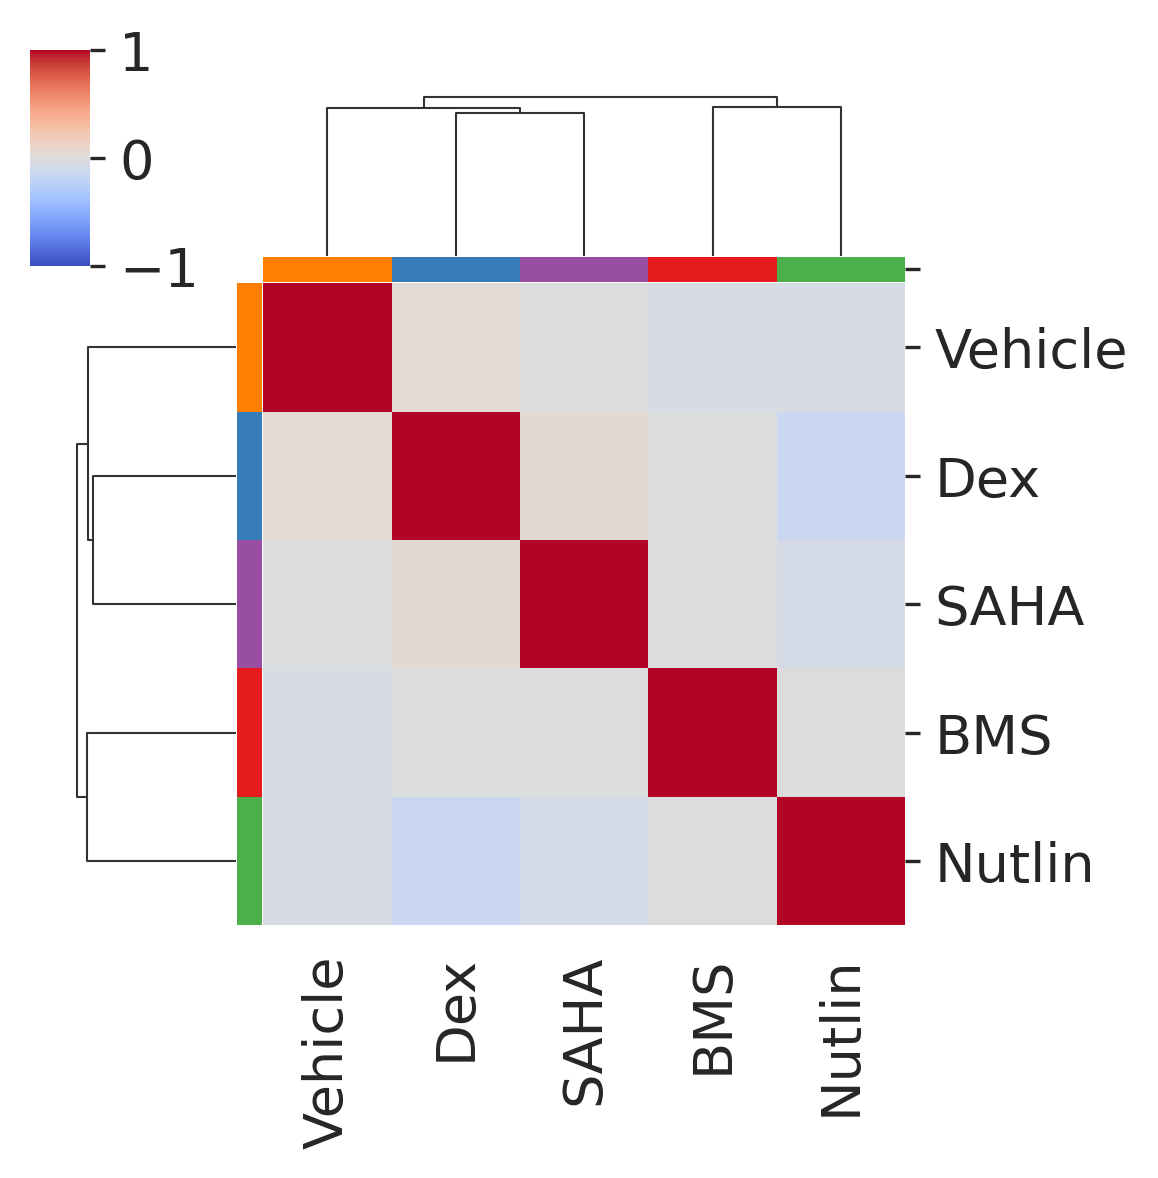

In [25]:
cpa_plots.plot_latent_embeddings(drug_adata.X, kind='perturbations', titlename='Drugs')

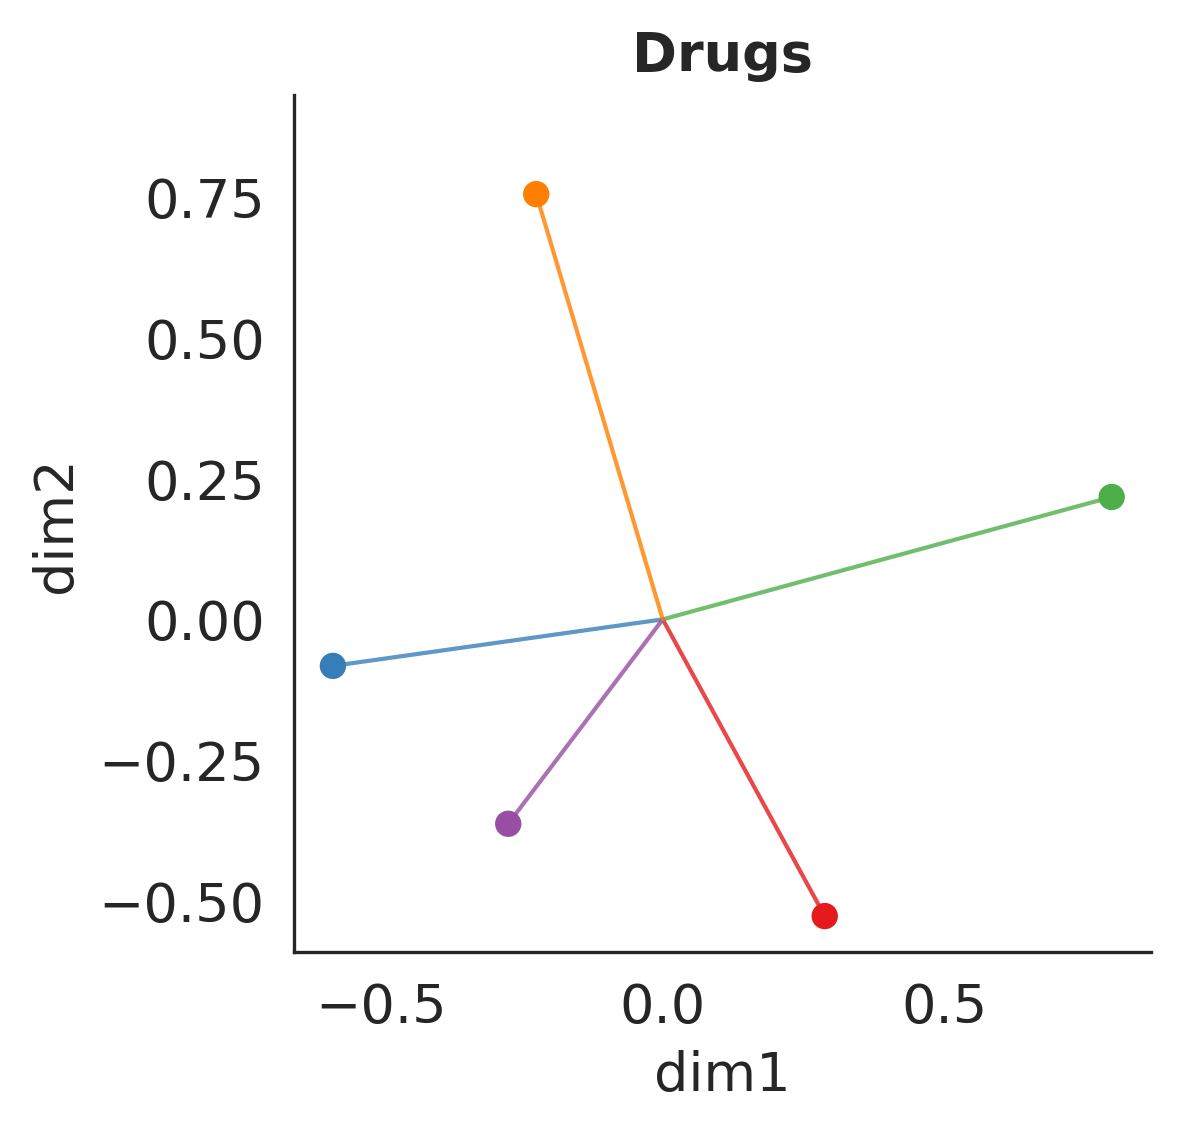

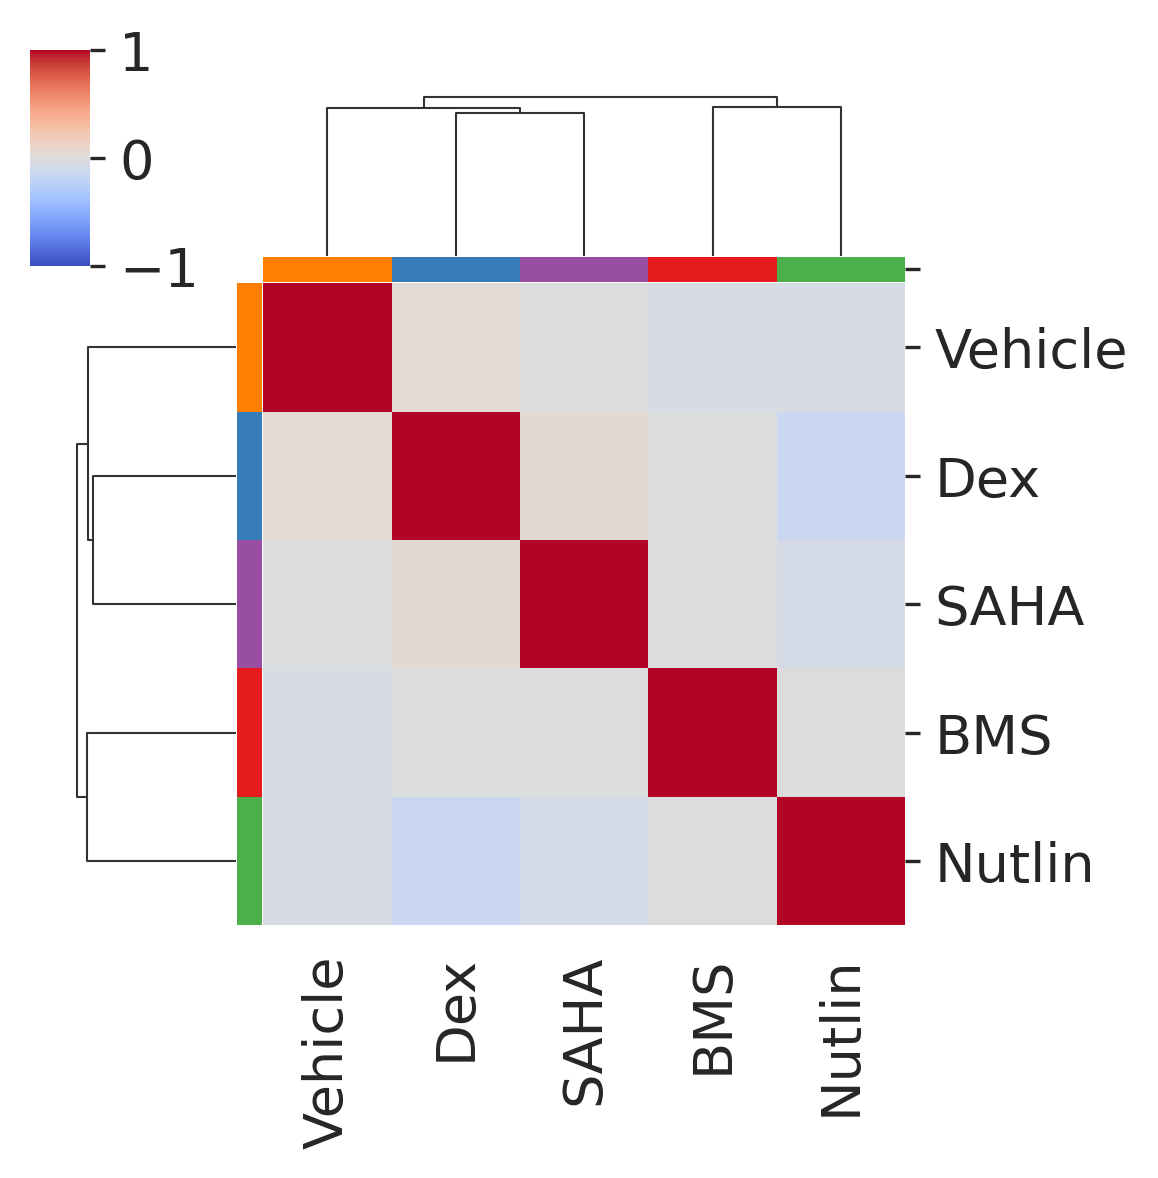

In [26]:
cpa_plots.plot_latent_embeddings(drug_adata.X, kind='perturbations', titlename='Drugs', show_text=False)

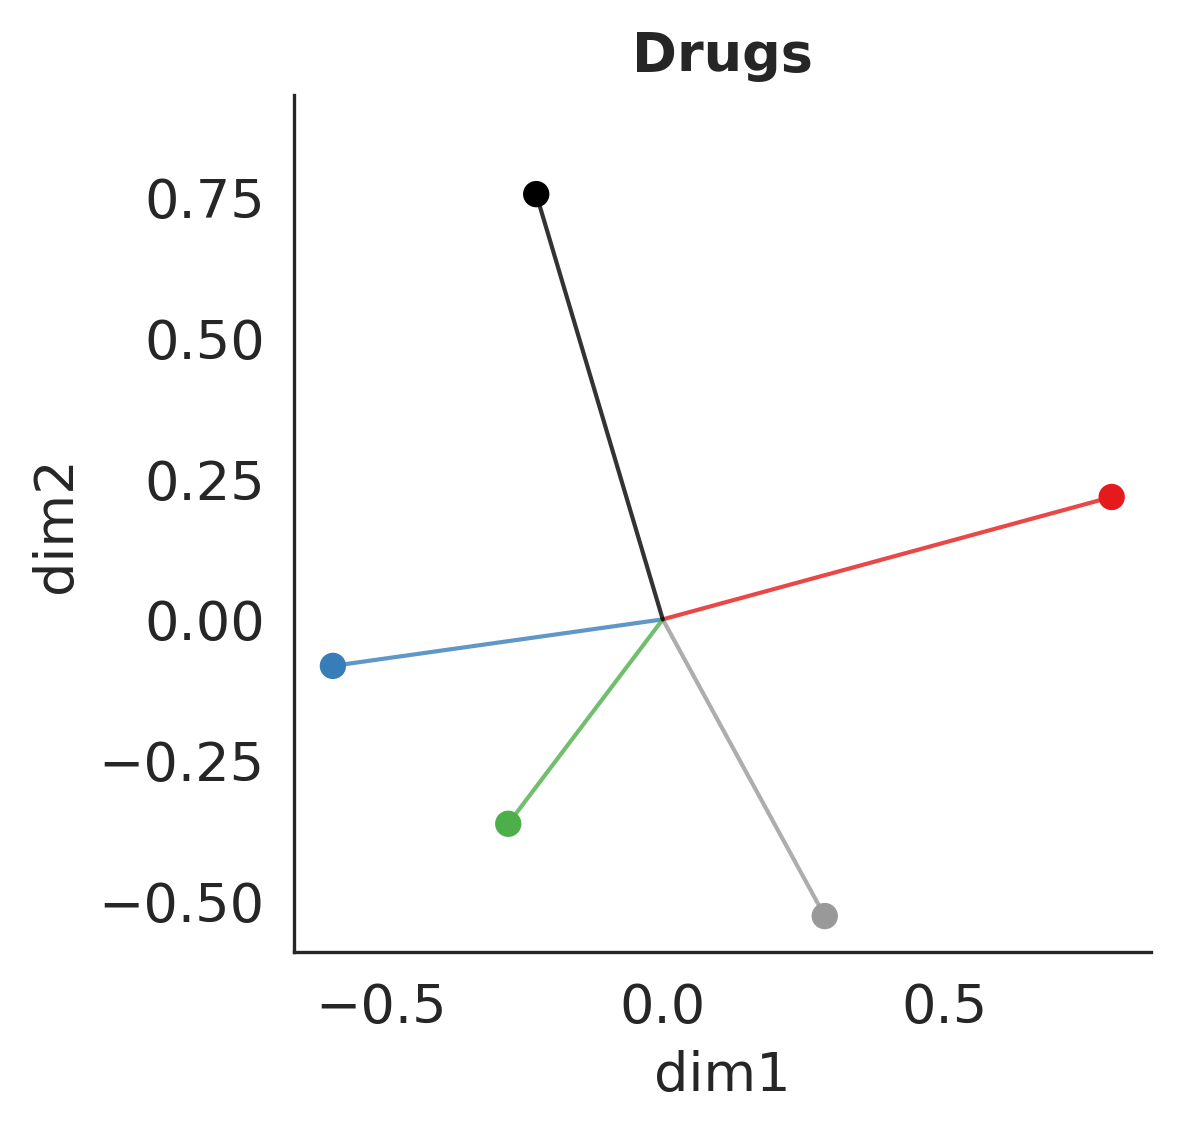

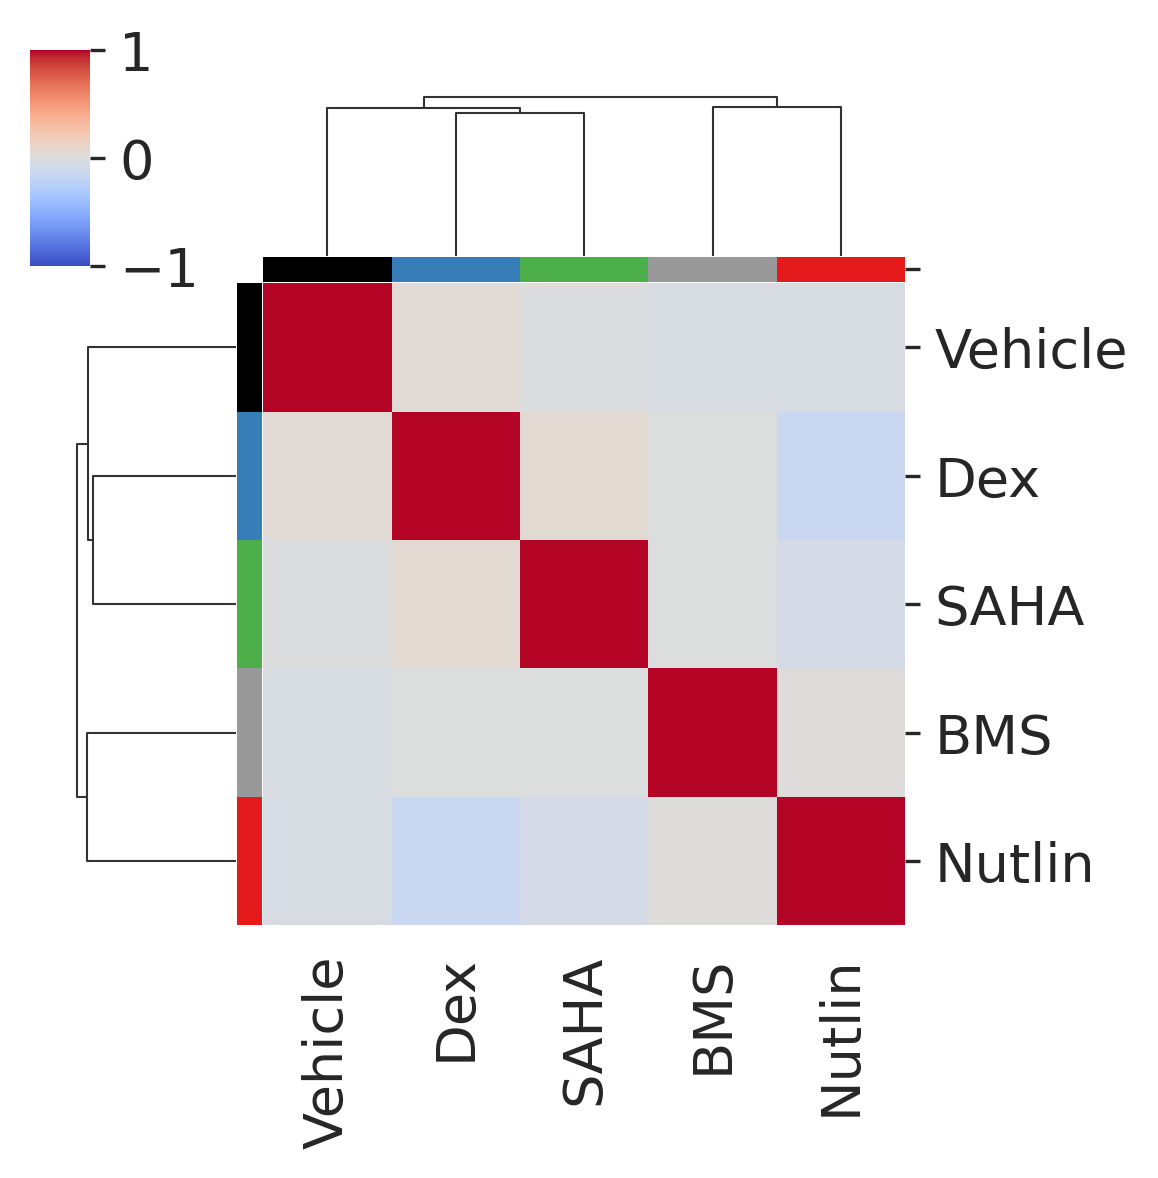

In [27]:
perts_palette = {'BMS': '#999999',                 
                 'SAHA': '#4daf4a',
                 'Dex': '#377eb8',
                 'Nutlin': '#e41a1c',
                 'Vehicle': '#000000'
    
                }

cpa_plots.perts_palette = perts_palette
cpa_plots.plot_latent_embeddings(drug_adata.X, kind='perturbations', titlename='Drugs', show_text=False)

In [28]:
cpa_plots.plot_latent_embeddings(cpa_analyzer.emb_covars, kind='cell_type')

Embedding contains only 1 vectors. Not enough to plot.


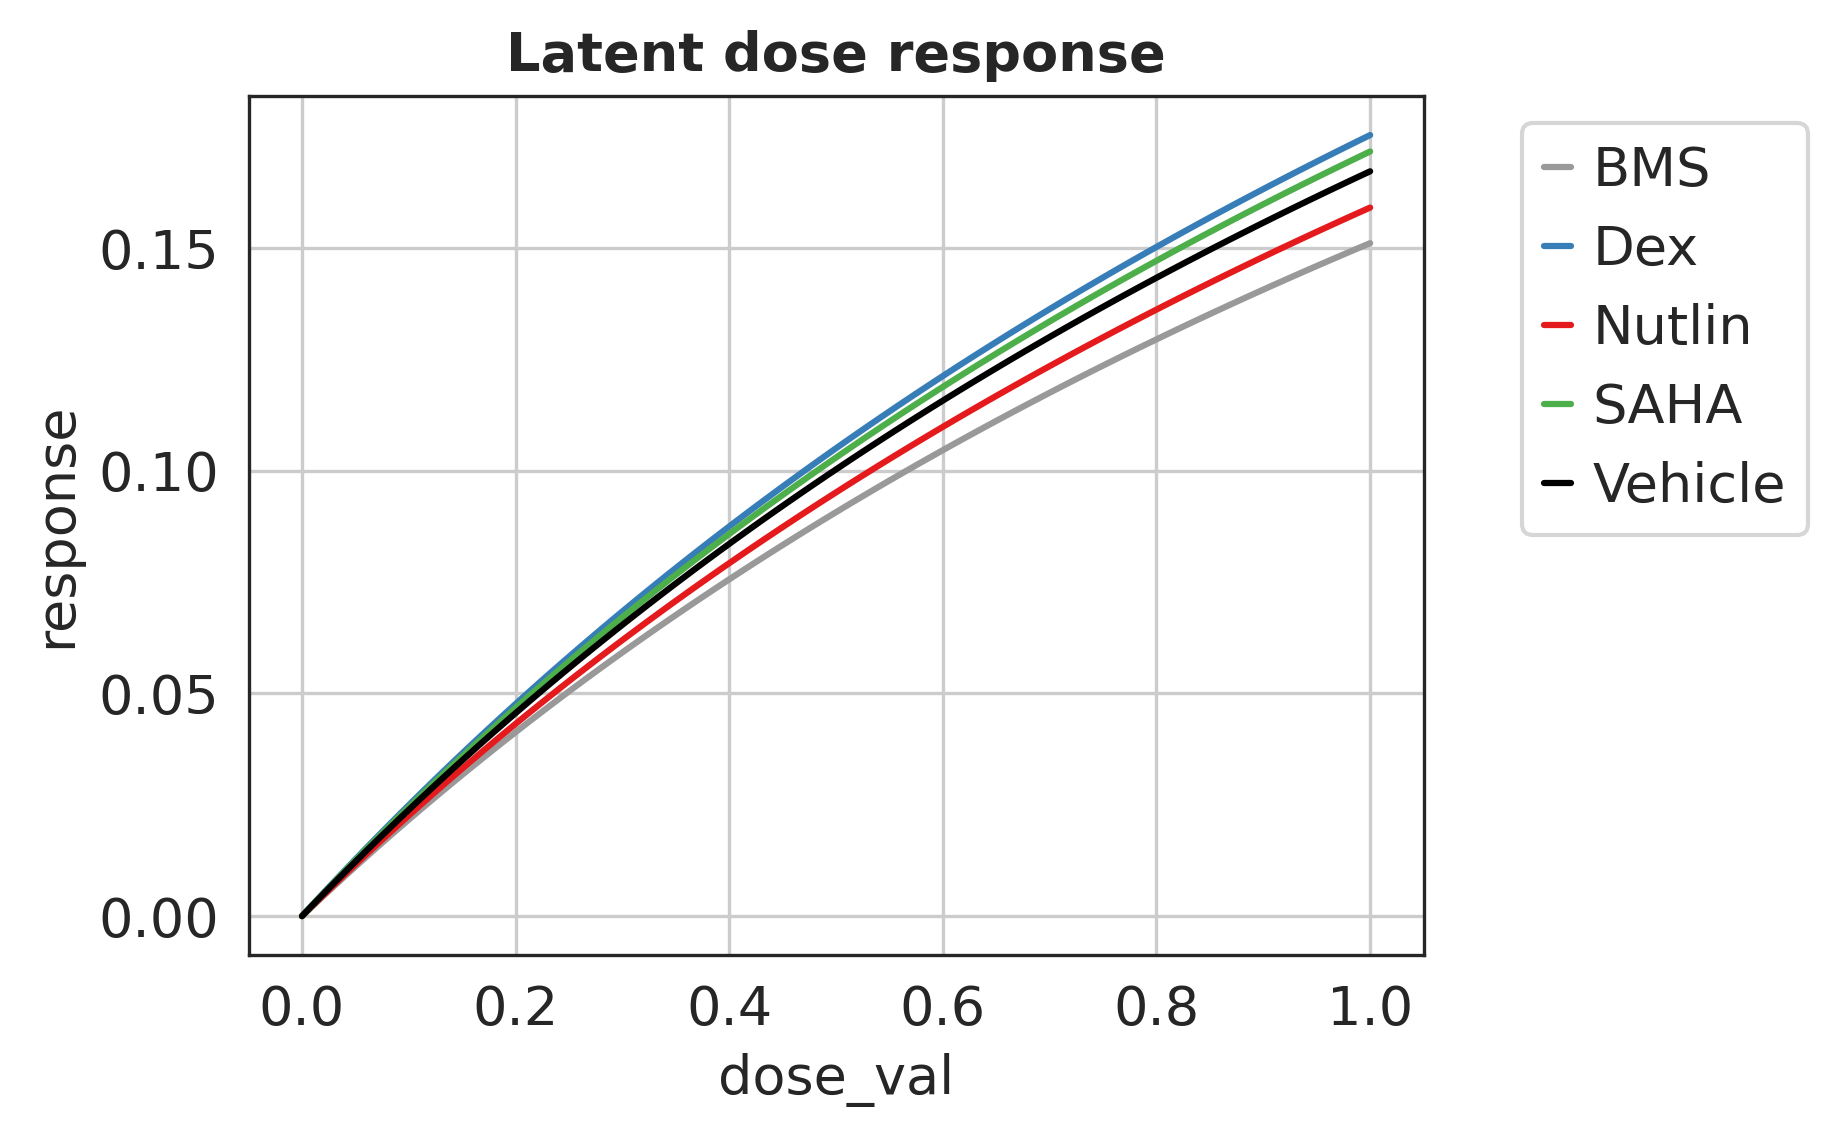

In [29]:
latent_response = cpa_analyzer.latent_dose_response(perturbations=None)
cpa_plots.plot_contvar_response(
    latent_response, 
    postfix='latent',
    var_name=cpa_analyzer.perturbation_key,
    title_name='Latent dose response')

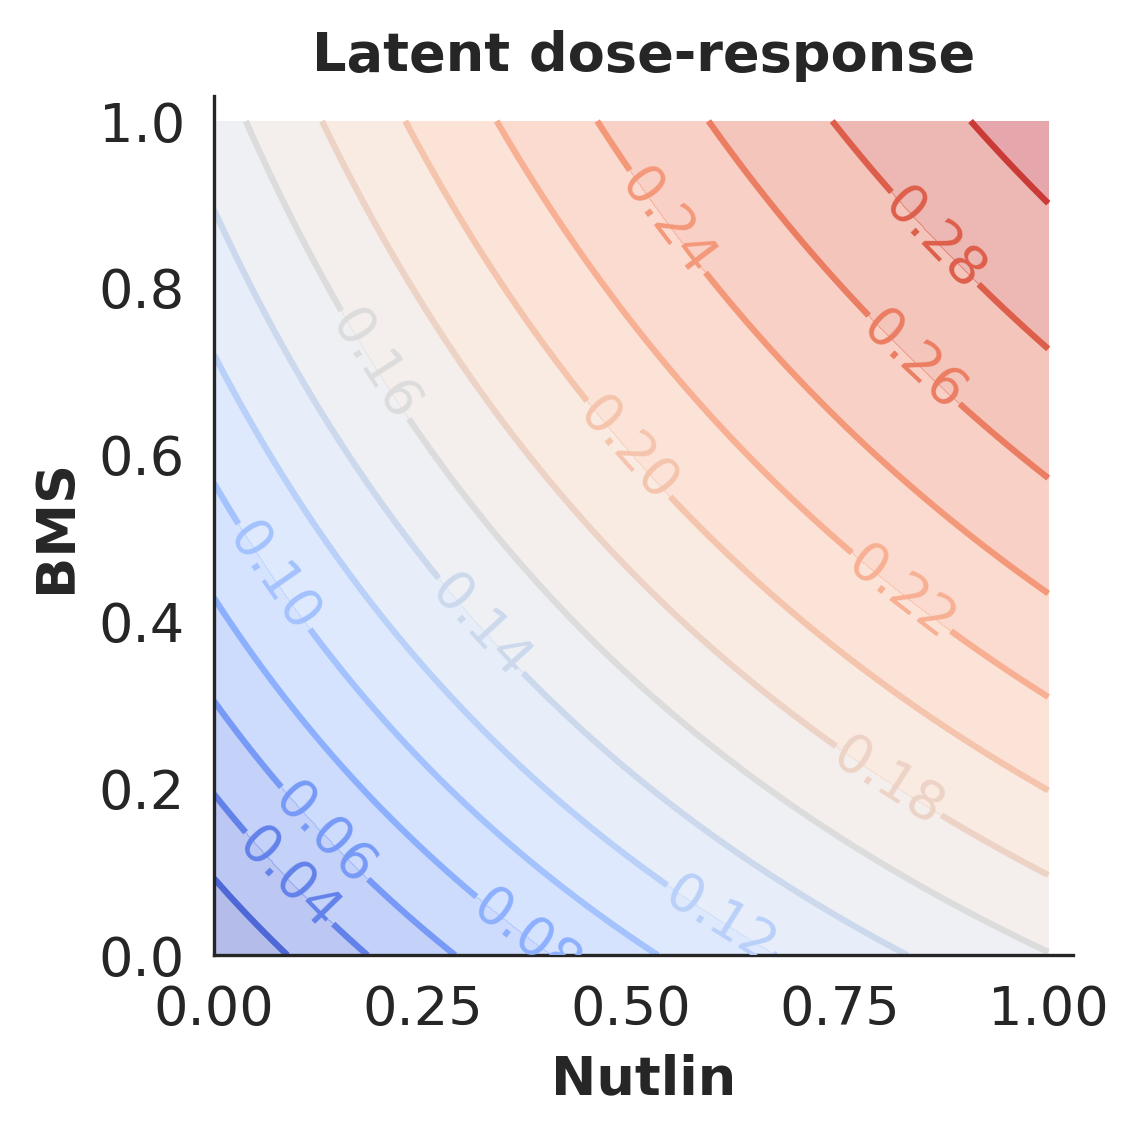

In [30]:
perturbations_pair = ['Nutlin', 'BMS']
latent_dose_2D = cpa_analyzer.latent_dose_response2D(perturbations_pair, n_points=100)
cpa_plots.plot_contvar_response2D(latent_dose_2D, 
        title_name='Latent dose-response')

In [31]:
%%time
reconstructed_response2D = cpa_analyzer.get_response2D(adata, perturbations_pair, cpa_analyzer.unique_covars['cell_type'])
cpa_plots.plot_contvar_response2D(reconstructed_response2D,
                                              title_name='Reconstructed dose-response  2D',
                                              logdose=False,
                                              # xlims=(-3, 0), ylims=(-3, 0)
                                              )

cpa_plots.plot_contvar_response2D(reconstructed_response2D,
                                      title_name='Reconstructed log10-dose-response 2D',
                                      logdose=True,
                                      xlims=(-3, 0), ylims=(-3, 0)
                                      )

KeyError: 'test_control'

In [14]:
df_reference = cpa_analyzer.get_response_reference(adata)

NotImplementedError: Equality comparisons are not supported for AnnData objects, instead compare the desired attributes.

In [36]:
reconstructed_response = cpa_analyzer.get_response(adata)

KeyError: 'test_control'

In [75]:
df_reference = df_reference.replace('training_treated', 'train')
cpa_plots.plot_contvar_response(
    reconstructed_response, 
    df_ref=df_reference, 
    postfix='reconstructed',
    title_name='Reconstructed dose response')

NameError: name 'df_reference' is not defined

### Prediction

In [79]:
print('Perturbations:', cpa_analyzer.unique_perts)
print('Covariates:', cpa_analyzer.unique_covars['cell_type'])
print('Datasets splits:', adata.keys())

Perturbations: ['BMS', 'Dex', 'Nutlin', 'SAHA', 'Vehicle']
Covariates: ['A549']


AttributeError: 'AnnData' object has no attribute 'keys'

In [81]:
genes_control = adata['test_control'].genes

KeyError: 'test_control'